In [1]:

import ctypes
ctypes.CDLL("libiomp5md.dll", mode=ctypes.RTLD_GLOBAL)

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import copy
import time

import pytorch_utils
import dataset_utils

import numpy as np

def one_hot(arr, n_classes):
    encoded = np.zeros((arr.shape[0], n_classes))
    encoded[np.arange(arr.shape[0]), arr.astype(int)] = 1
    return encoded

print("Loading npz dataset file...")
npz_file = np.load("WSe2_control_dataset.npz", allow_pickle = True)
X  = npz_file["X"]
Y1 = npz_file["Y1"]
Y2 = npz_file["Y2"]
Y2 = Y2[:, :, :, :2]
Y3 = npz_file["Y3"]

print(X.shape, Y1.shape, Y2.shape, Y3.shape)
print(X.dtype, Y1.dtype, Y2.dtype, Y3.dtype)

print("\nInitializing PyTorch...")
dataset = dataset_utils.MyDataset(0.9, 0.10, 0.00, X, Y2, True)
utils = pytorch_utils.Utils(dataset, True)

input_size  = utils.dataset.X.shape[1] * utils.dataset.X.shape[2]
output_size = utils.dataset.Y.shape[1]

print("Success!", input_size, output_size)

Loading npz dataset file...
(99999, 64, 64) (99999, 1) (99999, 64, 64, 2) (99999, 1)
uint8 int32 uint8 float64

Initializing PyTorch...
Cuda available:  True
Using Cuda:      True
NVIDIA GeForce RTX 3060
Success! 4096 64


In [2]:
from functools import reduce
from operator import __add__

class Conv2dSamePadding(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(Conv2dSamePadding, self).__init__(*args, **kwargs)
        self.zero_pad_2d = nn.ZeroPad2d(reduce(__add__,
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_size[::-1]]))

    def forward(self, input):
        return  self._conv_forward(self.zero_pad_2d(input), self.weight, self.bias)

class CNN(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, stride, activation):
        super().__init__()

        self.conv = Conv2dSamePadding(
            in_channels=channels_in, 
            out_channels=channels_out, 
            kernel_size=kernel_size, 
            stride = stride,
            bias=False
        )

        self.bn = nn.BatchNorm2d(channels_out)

        self.activation = activation

    def forward(self, x):
        x = self.bn(self.conv(x))
        if self.activation:
            x = F.leaky_relu(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, channels_in, channels_out, kernel_size, stride):
        super().__init__()
        
        self.cnn1 = CNN(channels_in , channels_out, kernel_size, stride, activation=True)
        self.cnn2 = CNN(channels_out, channels_out, kernel_size, 1     , activation=False)

        self.residual_scaling = nn.Parameter(torch.tensor(0.1), requires_grad=True)

        self.stride = stride
        self.channels_in = channels_in
        self.channels_out = channels_out
        
        self.downsample = None
        if self.stride > 1 or channels_out != channels_in:
            self.downsample = CNN(channels_in , channels_out, kernel_size = 1, stride=stride, activation=False)


    def forward(self, x):
        residual = self.downsample(x) if self.downsample is not None else x
        
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = x * self.residual_scaling + residual
        x = F.leaky_relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, params):
        super(ResNet, self).__init__()

        self.layers = nn.ModuleList()

        self.block_count = 1
        stages = 3
        filters_start = 64
        self.kernel_size = 3

        original_channels = 1

        self.layers.append(CNN(original_channels, filters_start, self.kernel_size, stride = 1, activation = True))
        prev_channels_out = filters_start
        for stage in range(stages):
            for block in range(self.block_count):
                channels_out = filters_start * (1 << stage)
                stride = 2 if stage > 0 and block == 0 else 1
                self.layers.append(ResidualBlock(prev_channels_out, channels_out, self.kernel_size, stride))
                prev_channels_out = channels_out

        self.layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        
        self.linear = nn.Linear(prev_channels_out, 1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        x = x.to(torch.float32)

        self.feature_maps = []
        for layer in self.layers:
            x = layer(x)
            if isinstance(layer, ResidualBlock):
                self.feature_maps.append(x.clone())

        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

    def get_input_weights(self):
        return torch.tensor(0)

In [3]:
def ConvTranspose2dSamePadding(in_channels, out_channels, kernel_size, stride, bias):
    padding = 0
    output_padding = 0
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size, stride=stride,
        padding=padding, output_padding=output_padding, bias=bias
    )

class UNet(nn.Module):
    def __init__(self, params):
        super(UNet, self).__init__()

        self.backbone = params['backbone']
        for param in self.backbone.parameters():
            param.requires_grad = False

        self.layers = nn.ModuleList()

        backbone_output = self.backbone(torch.zeros((1, 64, 64)).cuda())
        for feature_map in reversed(backbone.feature_maps):
            print(feature_map.shape)

        self.conv_layers     = nn.ModuleList()
        self.tconv_layers    = nn.ModuleList()
        self.bns             = nn.ModuleList()
        self.residual_blocks = nn.ModuleList()
        
        for i in range(len(backbone.feature_maps) - 1):
            feature_map = backbone.feature_maps[-i-2]
            filter_no = feature_map.shape[1]

            self.conv_layers.append(Conv2dSamePadding(
                                       in_channels  = filter_no, 
                                       out_channels = filter_no, 
                                       kernel_size  = 1, 
                                       stride       = 1,
                                       bias         = False
                                   ))
            self.tconv_layers.append(ConvTranspose2dSamePadding(
                                       in_channels  = filter_no*2, 
                                       out_channels = filter_no, 
                                       kernel_size  = 2, 
                                       stride       = 2,
                                       bias         = False
                                   ))
            self.bns.append(nn.BatchNorm2d(filter_no * 2))
            self.residual_blocks.append(ResidualBlock(filter_no * 2, filter_no, backbone.kernel_size, 1))

        self.final_conv = Conv2dSamePadding(
                                       in_channels  = filter_no, 
                                       out_channels = 2, 
                                       kernel_size  = backbone.kernel_size, 
                                       stride       = 1,
                                       bias         = True
                                   )

    def forward(self, x):
        #print(x.shape, (x.shape[0], 1, x.shape[1], x.shape[2]))
        #x = x.view(x.shape[0], 1, x.shape[1], x.shape[2])
        #print(x.shape)
        x = x.to(torch.float32)

        backbone_output = self.backbone(x)

        hidden = self.backbone.feature_maps[-1]
        for i in range(len(self.backbone.feature_maps) - 1):
            feature_map = self.backbone.feature_maps[-i-2]
            #print("feature_map", feature_map.shape)
            filter_no = feature_map.shape[1]

            #print(feature_map.shape)
            feature_map = self.conv_layers[i](feature_map)
            #print(hidden.shape, feature_map.shape)
            #print("hidden", hidden.shape)
            hidden = self.tconv_layers[i](hidden)
            #print(hidden.shape, feature_map.shape)
            hidden = torch.concatenate((feature_map, hidden), dim=1)
            hidden = self.bns[i](hidden)
            hidden = F.leaky_relu(hidden)
            hidden = self.residual_blocks[i](hidden)
            #print("hidden", hidden.shape)

        #print("hidden", hidden.shape)
        hidden = self.final_conv(hidden)
        output = F.sigmoid(hidden)
        
        output = torch.swapaxes(output, 1, 2)
        output = torch.swapaxes(output, 2, 3)
        #print(output.shape)
        return output
            
    def get_input_weights(self):
        return torch.tensor(0)
            

In [4]:
backbone = ResNet({})
backbone.load_state_dict(torch.load("Control_ResNet1.dict", weights_only=True))
backbone = backbone.cuda()

In [5]:
UNet_model = UNet({'backbone': backbone})

torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])


torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
gamma per epoch: 2.51188643150958
residual: 0.0
Test; 	Test loss: 0.0782987 	 time: 82s           

Initial: Train loss: 0.0782987

torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Step:1 	Train loss: 0.0092182 	LR: 5.00e-04	 time: 180s
torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Step:2 	Train loss: 0.0089264 	LR: 1.26e-03	 time: 178s
torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Step:3 	Train loss: 0.0089346 	LR: 3.15e-03	 time: 179s
torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Step:4 	Train loss: 0.0091437 	LR: 7.92e-03	 time: 181s
torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Step:5 	Train loss: 0.0096420 	LR: 1.99e-02	 time: 231s

Time to train: 1032.044s


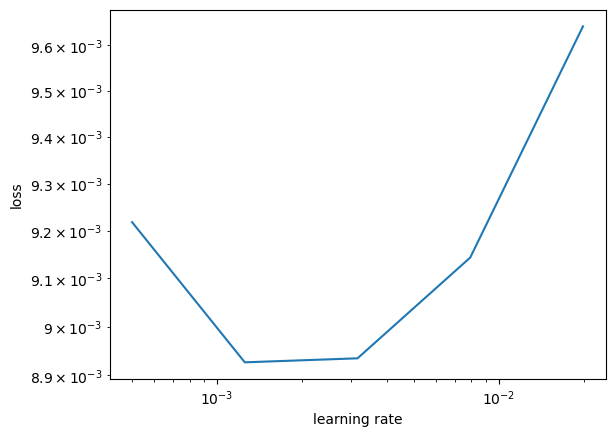

Best learning rate: 0.0012559432157547902
best_lr: 0.0012559432157547902


In [28]:
params = {'backbone': backbone, 'batch_size': 16, 'loss': F.smooth_l1_loss, 'weight_decay': 0, 'epochs': 5, 'lr': 1e-5, 'batch_growth': False, 'l1_reg': 0}

min_lr = 5e-4
max_lr = 5e-2

model, train_losses, learning_rates, best_lr_UNet = utils.Learning_Rate_Range_Test(UNet, min_lr, max_lr, params)
print("best_lr:", best_lr_UNet)

In [29]:
# best_lr_UNet = 0.0031547867224009664

params = {'backbone': backbone, 'batch_size': 16, 'loss': F.smooth_l1_loss, 'weight_decay': 0, 'epochs': 40, 'lr': best_lr_UNet, 'batch_growth': False, 'l1_reg': 0}
max_batch_size = 256
best_model, best_val_loss, final_model, train_losses, val_losses = utils.train_model(UNet, params, max_batch_size, print_mode=True)

torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Test; 	Test loss: 0.0835428 	 time: 18s           

Initial: Test loss: 0.0835428

torch.Size([1, 256, 16, 16])
torch.Size([1, 128, 32, 32])
torch.Size([1, 64, 64, 64])
Test; 	Test loss: 0.0079549 	 time: 21s           
Epoch:1 	Train loss: 0.0088990 	Val loss: 0.0079549 	batch size: 16	 LR: 1.25e-03	 time: 390s
Test; 	Test loss: 0.0076078 	 time: 19s           
Epoch:2 	Train loss: 0.0078285 	Val loss: 0.0076078 	batch size: 16	 LR: 1.25e-03	 time: 374s
Test; 	Test loss: 0.0074623 	 time: 17s           
Epoch:3 	Train loss: 0.0075758 	Val loss: 0.0074623 	batch size: 16	 LR: 1.24e-03	 time: 382s
Test; 	Test loss: 0.0073686 	 time: 17s           
Epoch:4 	Train loss: 0.0074317 	Val loss: 0.0073686 	batch size: 16	 LR: 1.23e-03	 time: 398s
Test; 	Test loss: 0.0073170 	 time: 20s           
Epoch:5 	Train loss: 0.0073314 	Val loss: 0.0073170 	batch size: 16	 LR: 1.21e-03	 time: 396s
Test; 	Test loss: 0.

In [30]:
torch.save(best_model.state_dict(), "Control_UNet1.dict")

In [31]:
UNet_model.load_state_dict(torch.load("Control_UNet1.dict", weights_only=True))
UNet_model.cuda()
UNet_model.eval()


UNet(
  (backbone): ResNet(
    (layers): ModuleList(
      (0): CNN(
        (conv): Conv2dSamePadding(
          1, 64, kernel_size=(3, 3), stride=(1, 1), bias=False
          (zero_pad_2d): ZeroPad2d((1, 1, 1, 1))
        )
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (cnn1): CNN(
          (conv): Conv2dSamePadding(
            64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False
            (zero_pad_2d): ZeroPad2d((1, 1, 1, 1))
          )
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (cnn2): CNN(
          (conv): Conv2dSamePadding(
            64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False
            (zero_pad_2d): ZeroPad2d((1, 1, 1, 1))
          )
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): ResidualBlock(
        (cnn1): CNN(
    

In [10]:
T_hat = pytorch_utils.predict(UNet_model, utils.dataset.X_val, 32)

In [11]:
sz = np.product(utils.dataset.Y_val.shape)
print(utils.dataset.Y_val.shape, sz)
test_loss = F.binary_cross_entropy(T_hat, utils.dataset.Y_val / 255, reduction="sum").item()
print(F.binary_cross_entropy(T_hat, utils.dataset.Y_val / 255, reduction="sum"))
print(test_loss / sz)


torch.Size([9999, 64, 64, 2]) 81911808
tensor(26483478., device='cuda:0')
0.3233169752522127


In [47]:
T_hat = pytorch_utils.predict(UNet_model, utils.dataset.X_val, 32)

sz = np.product(utils.dataset.Y_val.shape)
print(utils.dataset.Y_val.shape, sz)
test_loss = np.mean((T_hat.cpu().numpy() - utils.dataset.Y_val.cpu().numpy() / 256)**2)
print("Validation MSE: ", test_loss)

test_loss = np.mean(F.smooth_l1_loss(T_hat, utils.dataset.Y_val / 256).cpu().numpy())
print("Validation Smooth L1", test_loss)

print(np.var(utils.dataset.Y_val.cpu().numpy() / 256))

torch.Size([9999, 64, 64, 2]) 81911808
Validation MSE:  0.01371993584587056
Validation Smooth L1 0.006859968
0.0709644948728707


In [48]:
T_hat = pytorch_utils.predict(UNet_model, utils.dataset.X_train, 32)

sz = np.product(utils.dataset.Y_train.shape)
print(utils.dataset.Y_train.shape, sz)
test_loss = np.mean((T_hat.cpu().numpy() - utils.dataset.Y_train.cpu().numpy() / 256)**2)
print("Train MSE: ", test_loss)

test_loss = np.mean(F.smooth_l1_loss(T_hat, utils.dataset.Y_train / 256).cpu().numpy())
print("Train Smooth L1", test_loss)

torch.Size([89999, 64, 64, 2]) 737271808
Train MSE:  0.013098448545668068
Train Smooth L1 0.006549225


In [9]:

def bce_random_guess(y_true):
    """
    Computes the binary cross-entropy of a random guess equal to the mean of the targets.
    
    Parameters:
        y_true (np.ndarray): Array of binary targets (0 or 1).
        
    Returns:
        float: Binary cross-entropy of the random guess.
    """
    # Ensure it's a numpy array
    y_true = np.asarray(y_true)

    # Compute the mean probability (our fixed guess)
    p = np.mean(y_true)
    
    # Clip p to avoid log(0)
    p = np.clip(p, 1e-7, 1 - 1e-7)
    
    # Compute BCE of constant prediction p
    bce = -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    
    return bce
print(bce_random_guess(utils.dataset.Y_val.cpu().numpy() / 256))

0.5149815823791456


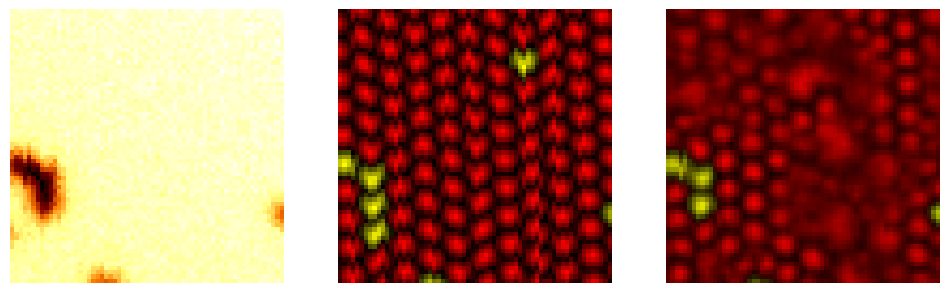

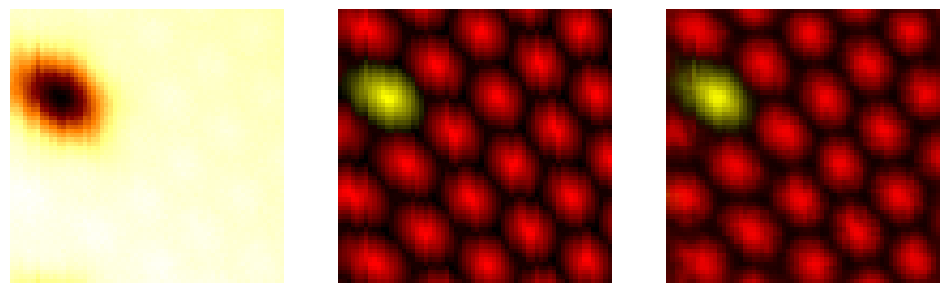

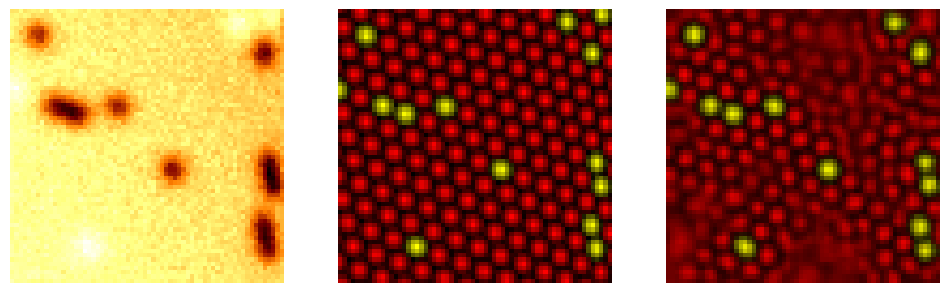

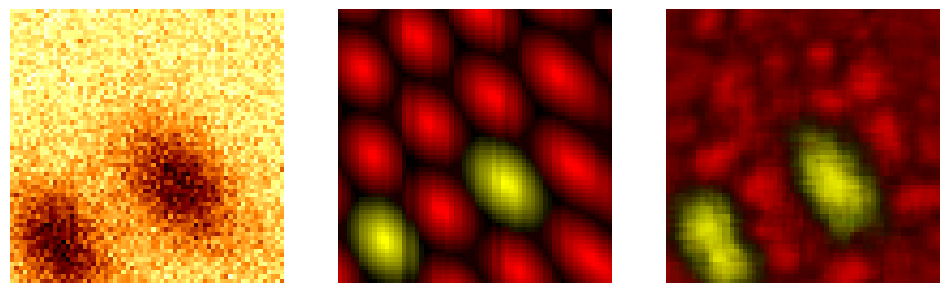

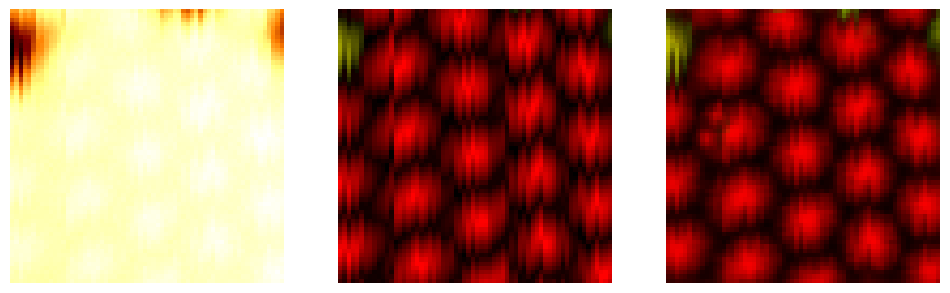

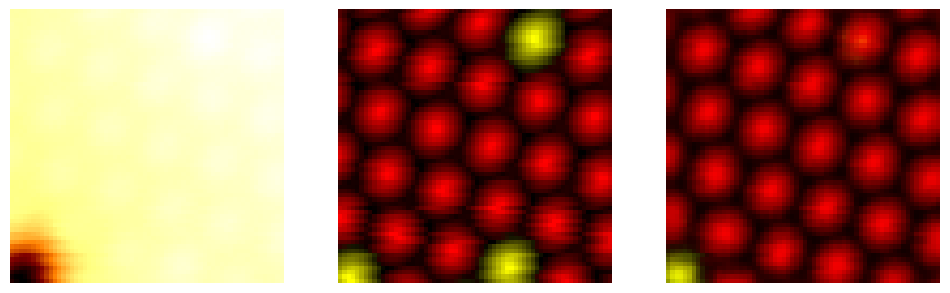

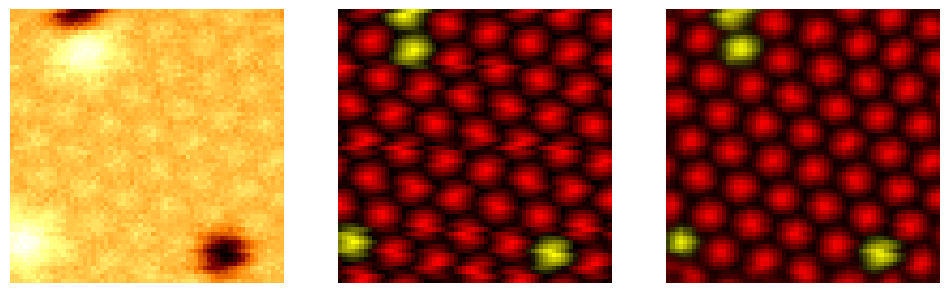

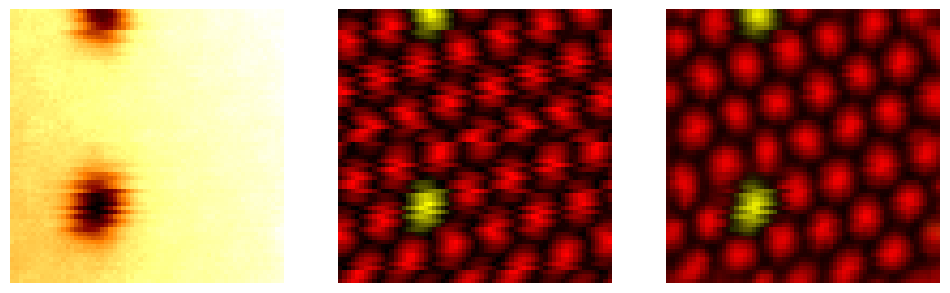

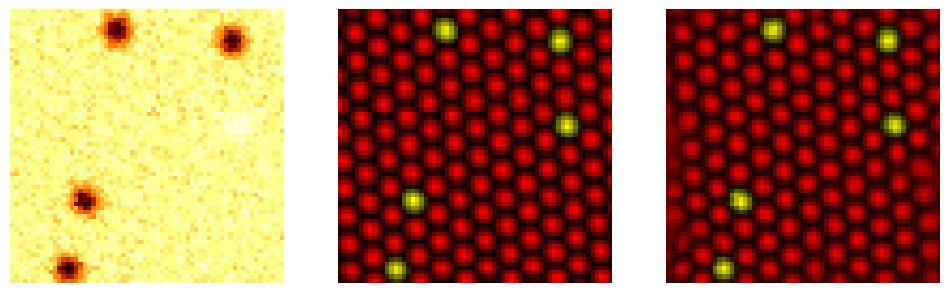

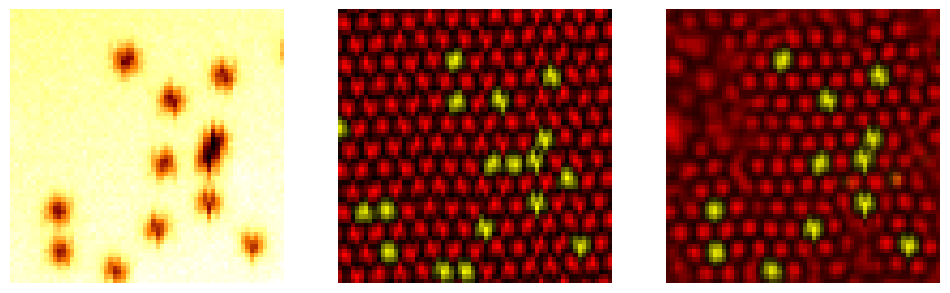

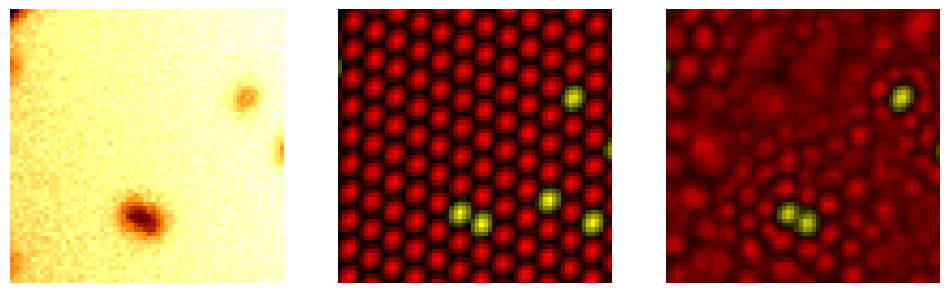

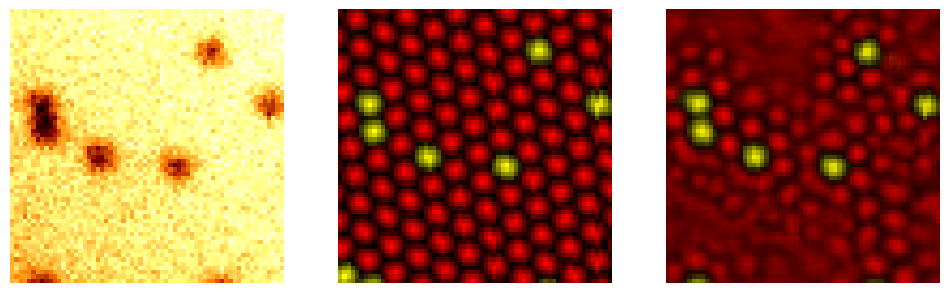

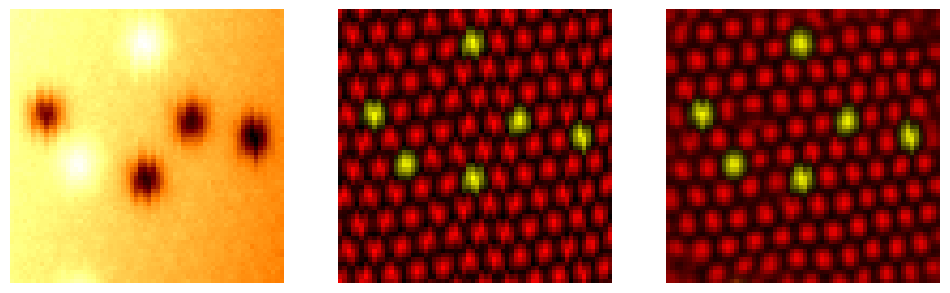

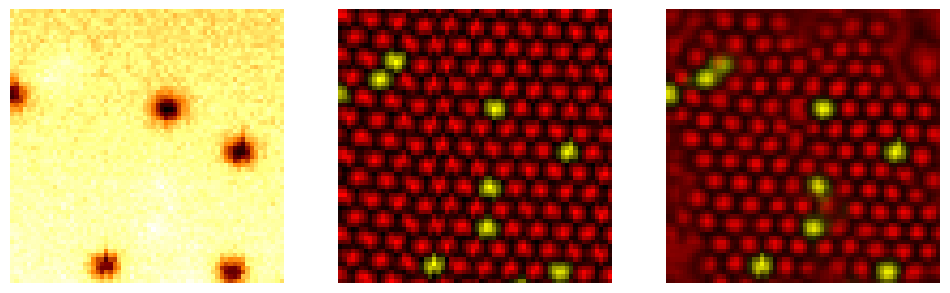

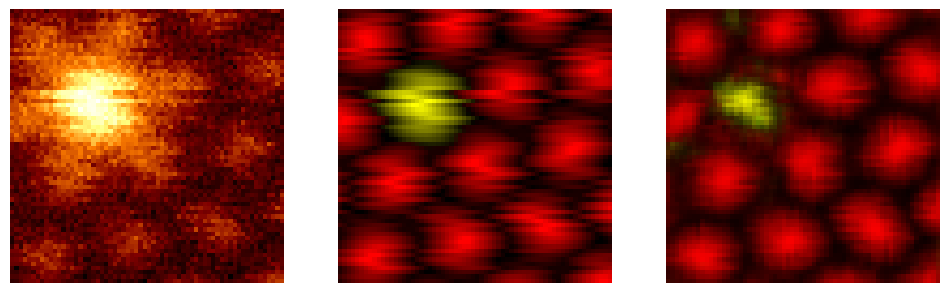

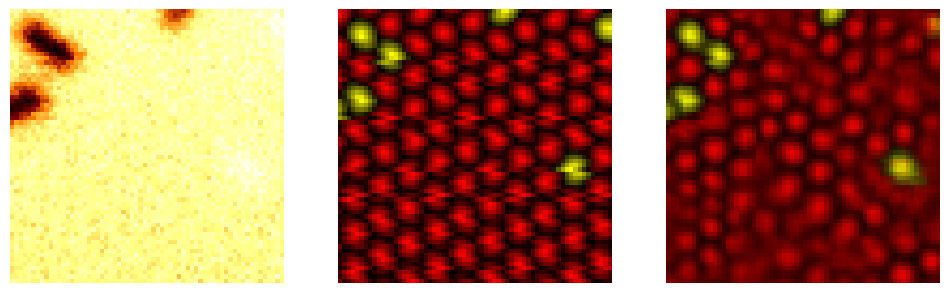

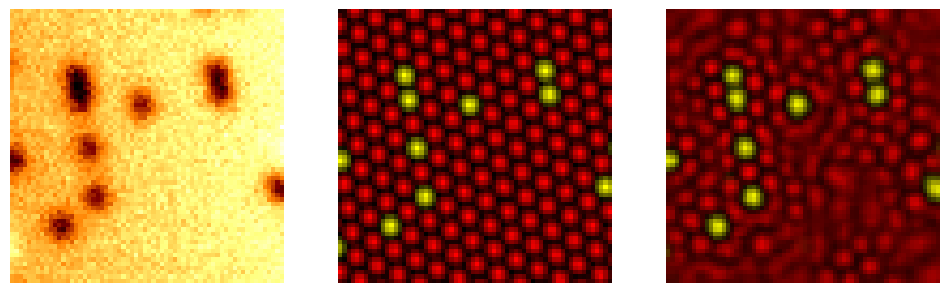

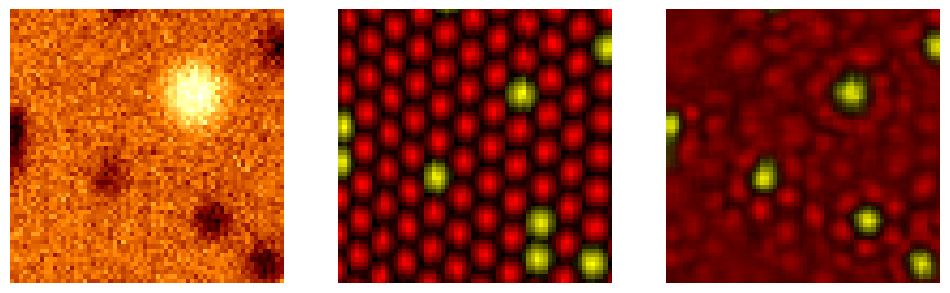

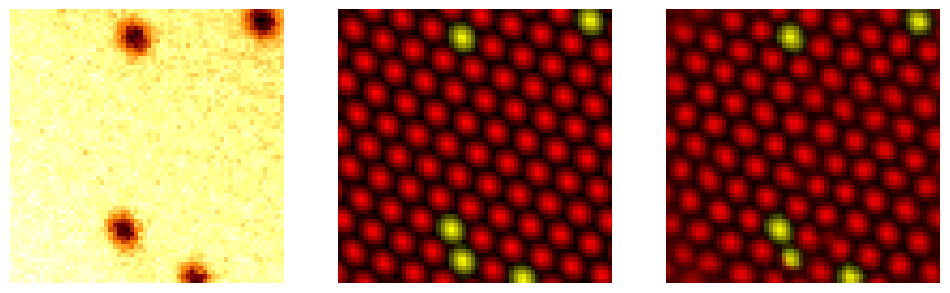

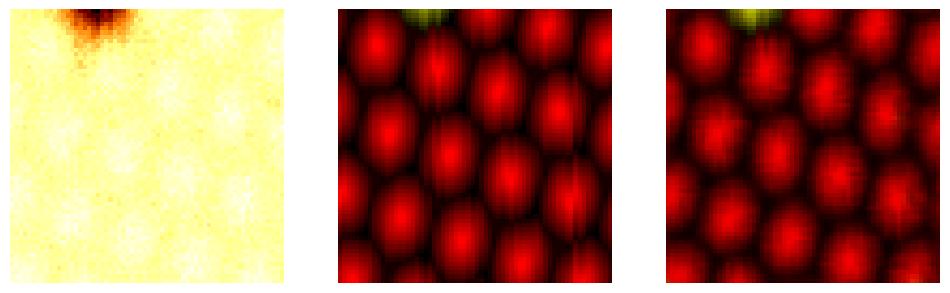

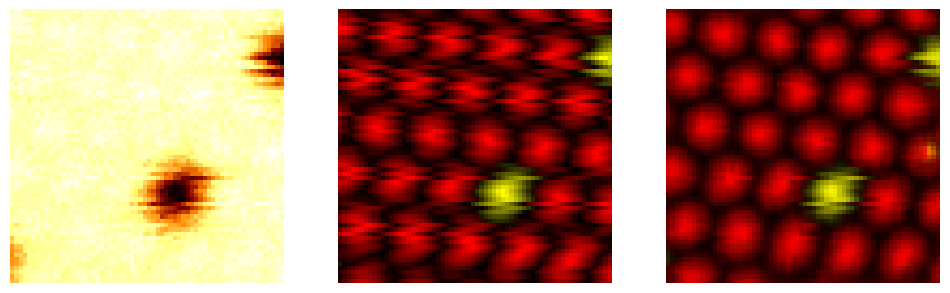

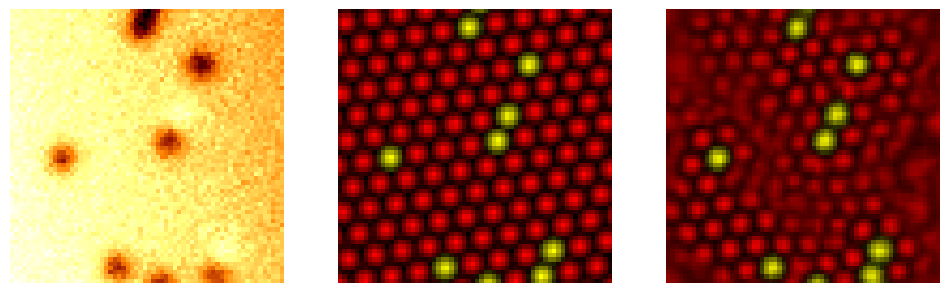

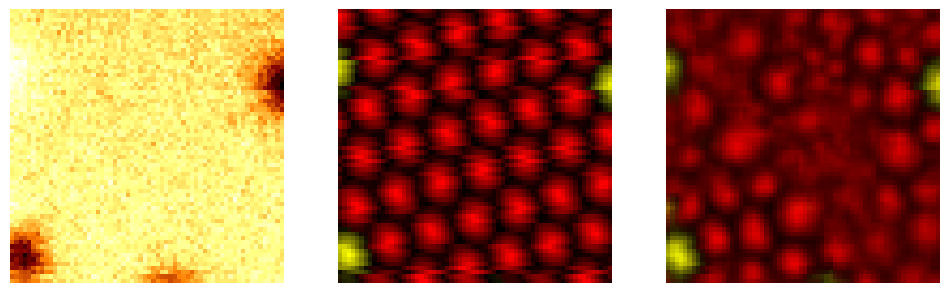

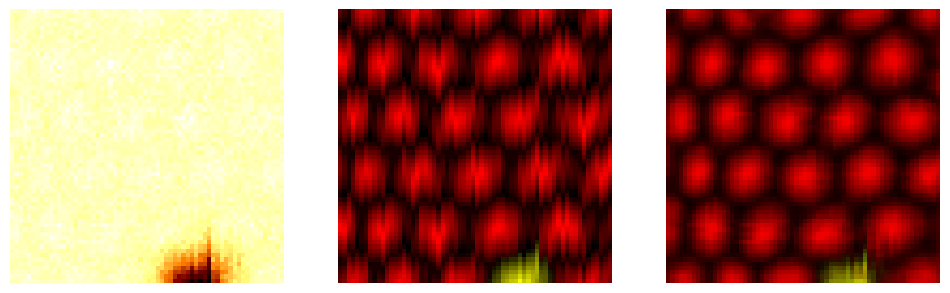

In [46]:
import matplotlib.pyplot as plt

huhu = 24

preds = UNet_model(utils.dataset.X_val[:huhu])
for i in range(huhu):
    plt.figure(figsize=(12, 7))  
    #print(utils.dataset.Y_test[i].shape, preds[i].shape)

    rgb_y = torch.concatenate((utils.dataset.Y_val[i].cpu() / 255.0, torch.zeros((64, 64, 1))), dim=2)
    rgb_p = torch.concatenate((preds[i].detach().cpu(), torch.zeros((64, 64, 1))), dim=2)
    
    plt.subplot(1, 3, 1)
    plt.imshow(utils.dataset.X_val[i].cpu(), cmap="afmhot")
    plt.gca().axis("off")
    # plt.title("Input")
    
    plt.subplot(1, 3, 2)
    plt.imshow(rgb_y)
    plt.gca().axis("off")
    # plt.title("Ground Truth")
    
    plt.subplot(1, 3, 3)
    plt.imshow(rgb_p)
    plt.gca().axis("off")
    # plt.title("Predicted")
    
    plt.show()

In [11]:
rgb_y = torch.concatenate((utils.dataset.Y_test[0].cpu(), torch.zeros((64, 64, 1))), dim=2)
rgb_p = torch.concatenate((preds[0].detach().cpu(), torch.zeros((64, 64, 1))), dim=2)

In [5]:
huhu = utils.dataset.X_test[0].cpu().numpy()

In [ ]:
plt.imshow(utils.dataset.X_test[0].cpu().numpy())

NameError: name 'best_model' is not defined

In [33]:
model = UNet_model

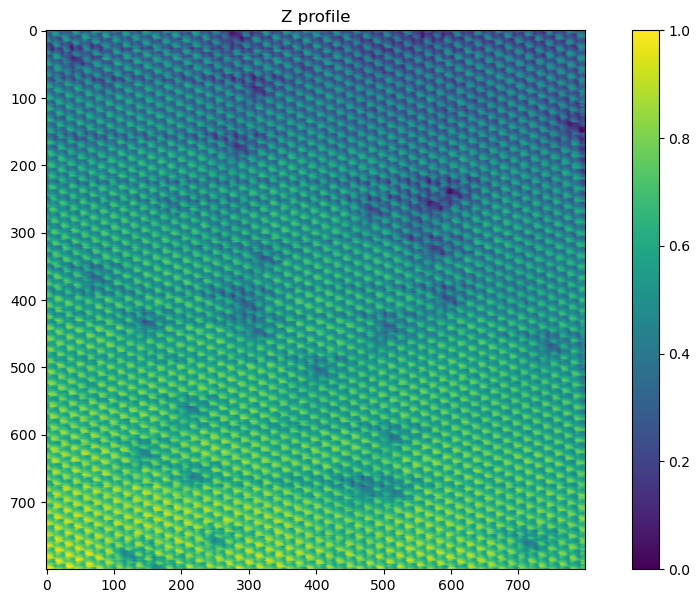

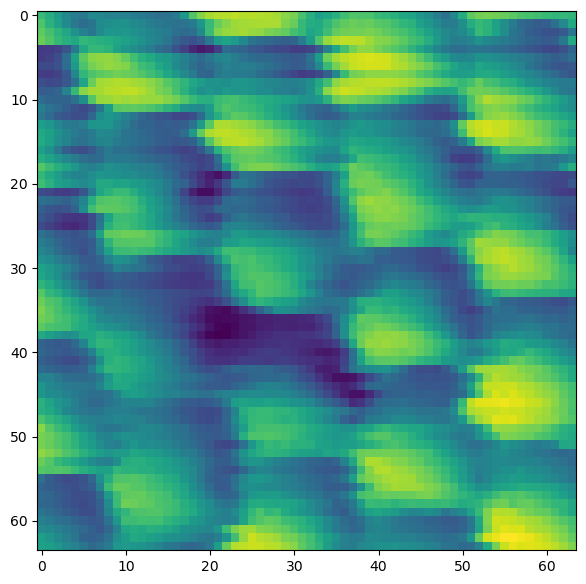

In [34]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def load_sample(path):
    with open(path, 'rb') as f:
        data = f.read()
        f.close()
    
    topo = []
    for i in range(int(len((data))/4)):
        topo_numvalue = struct.unpack('<i', data[4*i:4*i+4])[0]
        topo.append(topo_numvalue)
    
    topo = np.array(topo)
    res = int(np.sqrt(topo.shape[0]))
    topo = topo.reshape(res, res)
    #topo_min = np.min(topo, axis = 1)[:, None]
    #topo_max = np.max(topo, axis = 1)[:, None]
    #topo = (topo - topo_min) / (topo_max - topo_min)
    topo = (topo - np.min(topo)) / (np.max(topo) - np.min(topo))
    return topo

folder = "20230818_Lance_WSe2-CVD[10K]/"
#file = "20230818_Lance_WSe2-CVD_163TopoBwd.int"
file = "20230818_Lance_WSe2-CVD_164TopoBwd.int"

path = folder + file
topo = 1.0 - load_sample(path)

plt.figure(figsize=(12, 7)) 
plt.imshow(topo)

plt.title("Z profile")
plt.colorbar()
plt.show()

res = 64

off_x = 300
off_y = 300

test_sample = topo[off_x:off_x+res, off_y:off_y+res]

plt.figure(figsize=(12, 7)) 
plt.imshow(test_sample)
#plt.colorbar()
plt.show()


In [36]:
test_samples = []
test_samples.append(test_sample)

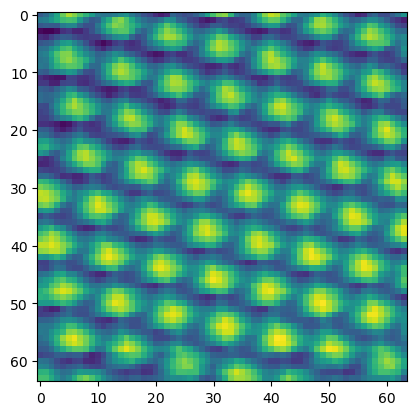

In [37]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_174TopoFwd.int"

path = folder + file
topo = 1.0 - load_sample(path)

crop_sz = 384
topo_re = cv2.resize(topo[:crop_sz, :crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)

test_samples.append(topo_re)

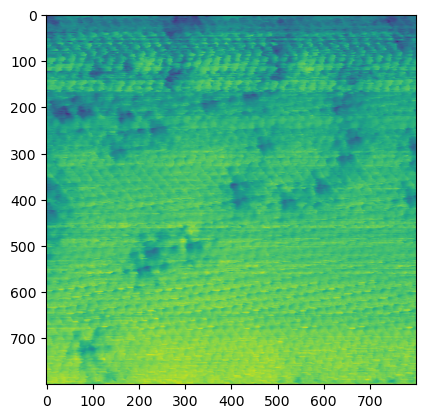

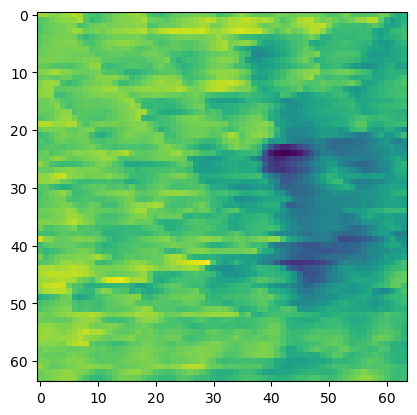

In [38]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_112TopoFwd.int"

path = folder + file
topo = 1.0 - load_sample(path)
plt.imshow(topo)
plt.show()

crop_off = 320
crop_sz = 128
topo_re = cv2.resize(topo[crop_off:crop_off+crop_sz, crop_off:crop_off+crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)
plt.show()

test_samples.append(topo_re)

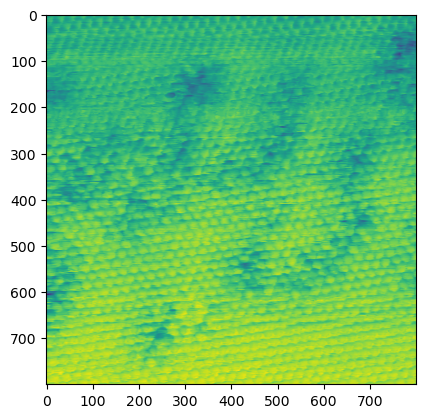

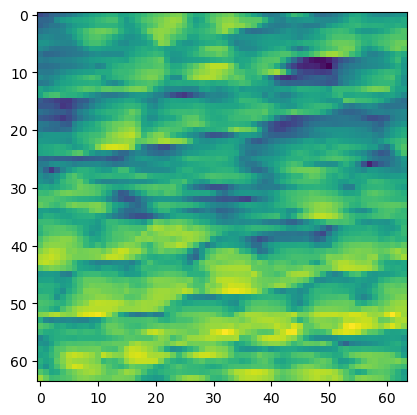

In [39]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_110TopoFwd.int"

path = folder + file
topo = 1.0 - load_sample(path)
plt.imshow(topo)
plt.show()

crop_off = 300
crop_sz = 128
topo_re = cv2.resize(topo[crop_off:crop_off+crop_sz, crop_off:crop_off+crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)
plt.show()

test_samples.append(topo_re)

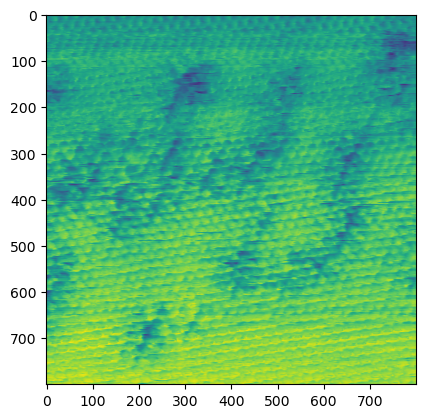

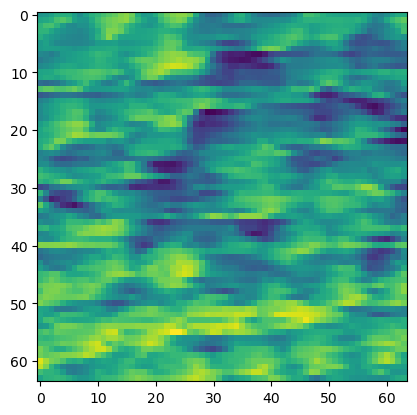

In [40]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_110TopoBwd.int"

path = folder + file
topo = 1.0 - load_sample(path)
plt.imshow(topo)
plt.show()

crop_off = 300
crop_sz = 128
topo_re = cv2.resize(topo[crop_off:crop_off+crop_sz, crop_off:crop_off+crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)
plt.show()

test_samples.append(topo_re)

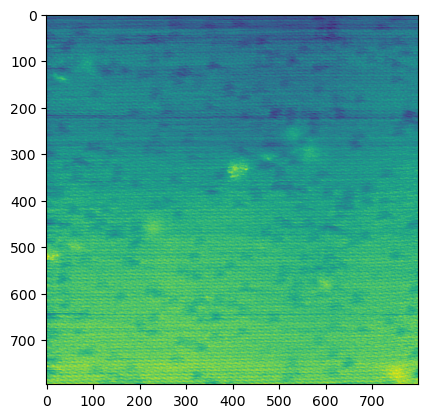

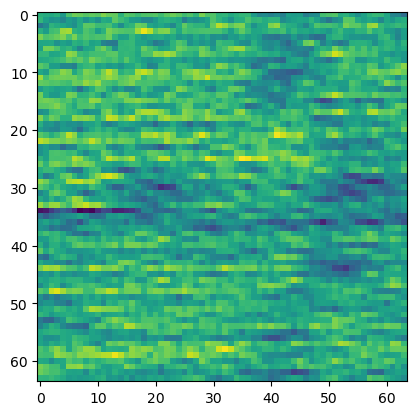

In [41]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_90TopoFwd.int"

path = folder + file
topo = 1.0 - load_sample(path)[:-5, :]
plt.imshow(topo)
plt.show()

crop_off = 150
crop_sz = 128
topo_re = cv2.resize(topo[crop_off:crop_off+crop_sz, crop_off:crop_off+crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)
plt.show()


test_samples.append(topo_re)

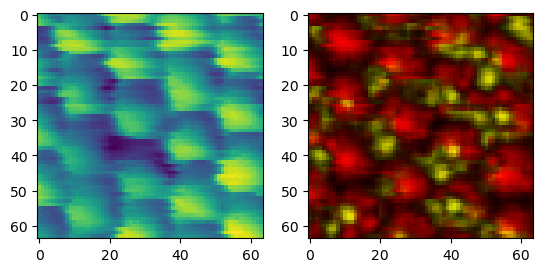

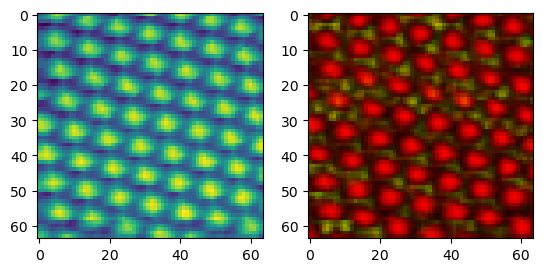

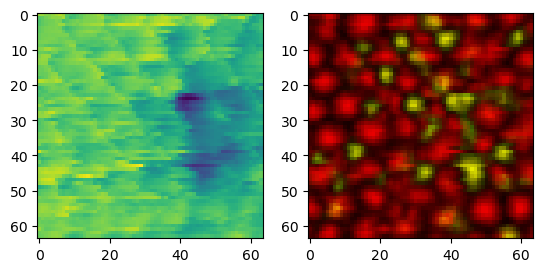

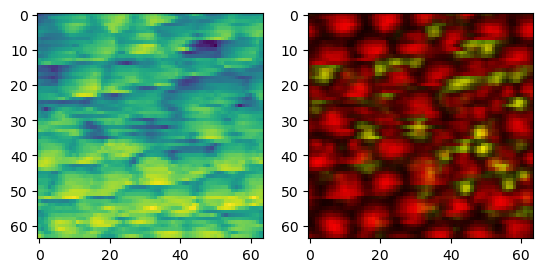

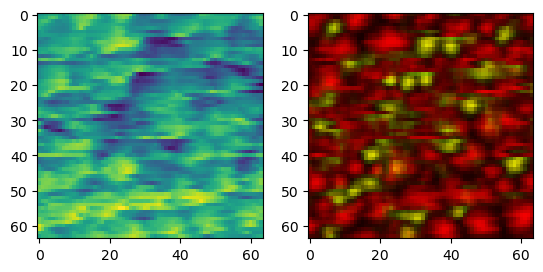

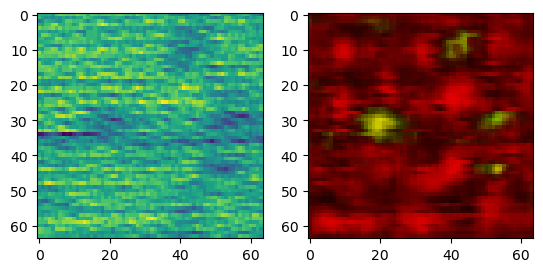

In [42]:
for test_sample in test_samples:
    test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype = torch.float16).cuda()
    test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
    
    pred = model(test_sample_t * 255)[0]
    
    rgb_p = torch.concatenate((pred.detach().cpu(), torch.zeros((64, 64, 1))), dim=2)
    
    plt.subplot(1, 2, 1)
    plt.imshow(test_sample_t[0].cpu())
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_p)
    plt.show()
    
# Save the plot as a PNG file
# plt.savefig("testing.png", dpi=300, bbox_inches='tight')

In [50]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from io import BytesIO

model = UNet_model

left_plots = []
right_plots = []

for i, test_sample in enumerate(test_samples):
    # Prepare input
    test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype=torch.float16).cuda()
    test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
    
    pred = model(test_sample_t * 255)[0]
    rgb_p = torch.concatenate((pred.detach().cpu(), torch.zeros((64, 64, 1))), dim=2)

    ### --- LEFT PLOT (input) ---
    fig, ax = plt.subplots()
    im = ax.imshow(test_sample_t[0].cpu(), cmap='afmhot')
    ax.axis("off")
    # ax.set_title(f"Input {i}")
    # fig.colorbar(im, ax=ax)
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    left_plots.append(Image.open(buf).convert("RGB"))
    plt.close(fig)

    ### --- RIGHT PLOT (prediction) ---
    fig, ax = plt.subplots()
    ax.imshow(rgb_p)
    ax.axis("off")
    # ax.set_title(f"Prediction {i}")
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    right_plots.append(Image.open(buf).convert("RGB"))
    plt.close(fig)

# Function to stack vertically
def stack_vertically(images):
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)
    stacked_img = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for im in images:
        stacked_img.paste(im, (0, y_offset))
        y_offset += im.size[1]
    return stacked_img

# Save final images
stack_vertically(left_plots).save("column_left_control.png")
stack_vertically(right_plots).save("column_right_control.png")


In [48]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image

left_images = []
right_images = []

for test_sample in test_samples:
    # Prepare input
    test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype=torch.float16).cuda()
    test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
    
    pred = model(test_sample_t * 255)[0]
    rgb_p = torch.concatenate((pred.detach().cpu(), torch.zeros((64, 64, 1))), dim=2)
    
    # Convert to numpy image arrays
    left_img = test_sample_t[0].cpu().numpy()
    right_img = rgb_p.numpy()

    # Normalize and convert to uint8
    left_img = (left_img * 255).astype(np.uint8)
    right_img = (right_img * 255).astype(np.uint8)

    # Convert to PIL Image
    left_pil = Image.fromarray(left_img)
    right_pil = Image.fromarray(right_img)

    # If grayscale, convert to RGB to avoid issues
    if left_pil.mode != 'RGB':
        left_pil = left_pil.convert("RGB")
    if right_pil.mode != 'RGB':
        right_pil = right_pil.convert("RGB")

    left_images.append(left_pil)
    right_images.append(right_pil)

# Stack images vertically
def stack_vertically(images):
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)

    stacked_img = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for im in images:
        stacked_img.paste(im, (0, y_offset))
        y_offset += im.size[1]

    return stacked_img

# Save final column images
stack_vertically(left_images).save("column_left.png")
stack_vertically(right_images).save("column_right.png")


In [51]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
from io import BytesIO

left_plots = []
right_plots = []

for i, test_sample in enumerate(test_samples):
    # Prepare input
    test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype=torch.float16).cuda()
    test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
    
    pred = model(test_sample_t * 255)[0]
    rgb_p = torch.concatenate((pred.detach().cpu(), torch.zeros((64, 64, 1))), dim=2)

    ### --- LEFT PLOT (input) ---
    fig, ax = plt.subplots()
    im = ax.imshow(test_sample_t[0].cpu())
    # ax.set_title(f"Input {i}")
    # fig.colorbar(im, ax=ax)
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    left_plots.append(Image.open(buf).convert("RGB"))
    plt.close(fig)

    ### --- RIGHT PLOT (prediction) ---
    fig, ax = plt.subplots()
    ax.imshow(rgb_p)
    # ax.set_title(f"Prediction {i}")
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    right_plots.append(Image.open(buf).convert("RGB"))
    plt.close(fig)

# Function to stack vertically
def stack_vertically(images):
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)
    stacked_img = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for im in images:
        stacked_img.paste(im, (0, y_offset))
        y_offset += im.size[1]
    return stacked_img

# Save final images
stack_vertically(left_plots).save("column_left.png")
stack_vertically(right_plots).save("column_right.png")


In [ ]:
for i in range(len(test_samples)):
    test_sample = test_samples[i]
    test_sample_t = torch.from_numpy(test_sample.reshape((1, res, res))).to(dtype = torch.float16).cuda()
    test_sample_t = (test_sample_t - torch.min(test_sample_t)) / (torch.max(test_sample_t) - torch.min(test_sample_t))
    
    pred = model(test_sample_t * 255)[0]
    
    rgb_p = torch.concatenate((pred.detach().cpu(), torch.zeros((64, 64, 1))), dim=2)
    
    # plt.figure(figsize=(12, 7))
    plt.subplot(len(test_samples), 2, i+1)
    plt.imshow(test_sample_t[0].cpu())
    # plt.title("Input")
    plt.subplot(len(test_samples), 2, i+2)
    plt.imshow(rgb_p)
    # plt.title("Predicted")
    
# Save the plot as a PNG file
plt.savefig("testing.png", dpi=300, bbox_inches='tight')

In [16]:
backbone(test_sample_t)

tensor([[0.8218]], device='cuda:0')

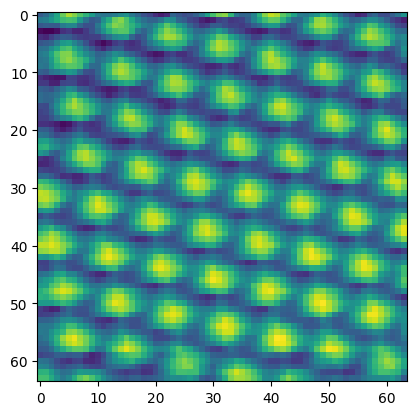

In [18]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_174TopoFwd.int"

path = folder + file
topo = 1.0 - load_sample(path)

crop_sz = 384
topo_re = cv2.resize(topo[:crop_sz, :crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo_re)

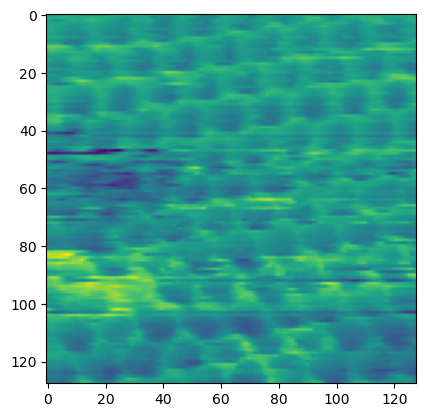

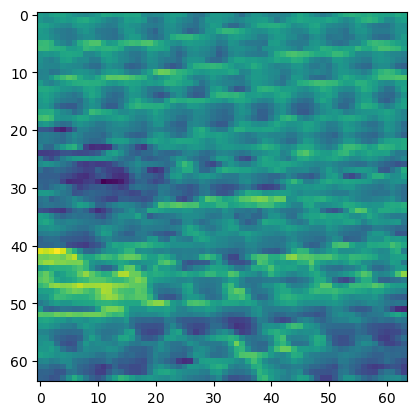

In [43]:
import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_62TopoFwd.int"

path = folder + file
topo = load_sample(path)

crop_sz = 128
topo_re = cv2.resize(topo[:crop_sz, :crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo[:crop_sz, :crop_sz])
plt.show()
plt.imshow(topo_re)
plt.show()

test_samples.append(topo_re)

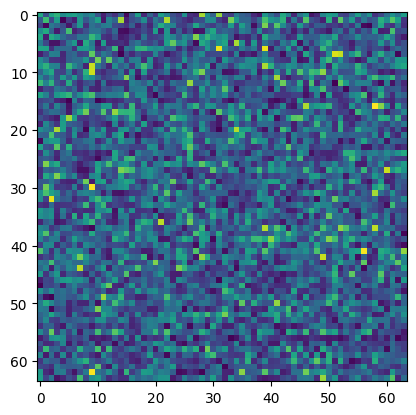

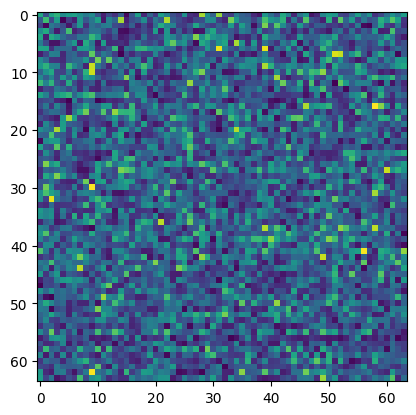

In [29]:

import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_129Lia2RBwd.int"

path = folder + file
topo = load_sample(path)

crop_sz = 64
topo_re = cv2.resize(topo[:crop_sz, :crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo[:crop_sz, :crop_sz])
plt.show()
plt.imshow(topo_re)
plt.show()

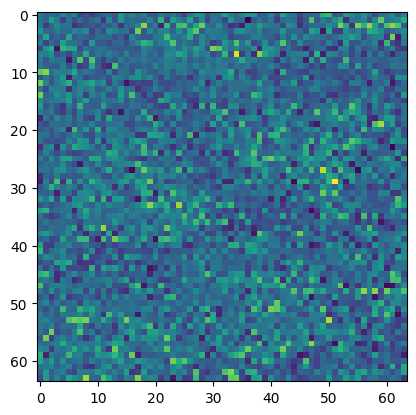

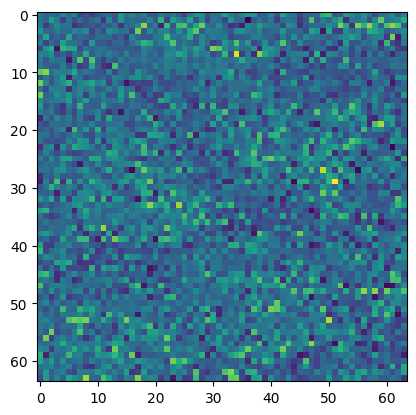

In [33]:

import cv2
folder = "20230818_Lance_WSe2-CVD[10K]/"
file = "20230818_Lance_WSe2-CVD_131Lia1RBwd.int"

path = folder + file
topo = load_sample(path)

crop_sz = 64
topo_re = cv2.resize(topo[:crop_sz, :crop_sz], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
plt.imshow(topo[:crop_sz, :crop_sz])
plt.show()
plt.imshow(topo_re)
plt.show()